# Analyzing Subnetworks

This notebook provides an example of analyzing subnetworks for a study that uses drugs to target transcription factors.  We care about networks where proteins bind / inhibit / activate each other.

In [ ]:
!brew install graphviz

In [1]:
# Reference: https://pygraphviz.github.io/documentation/stable/install.html
!pip install -q pygraphviz \
    --config-settings=--global-option=build_ext \
    --config-settings=--global-option="-I$(brew --prefix graphviz)/include" \
    --config-settings=--global-option="-L$(brew --prefix graphviz)/lib"

In [ ]:
!pip install -q git+https://github.com/gyorilab/adeft.git

In [2]:
!pip install -q -r requirements.txt

## STEP 1: ID CONVERSION

INDRA Cogex only accepts HGNC IDs at the time of this writing.  However, the dataset provided in the example above contains uniprot mnemonic IDs.  

Luckily, INDRA has code to convert uniprot mnemonic IDs into HGNC ids. For now, we will store this mapping in a separate dictionary

In [1]:
from indra.databases import uniprot_client

def uniprot_to_hgnc_id(uniprot_mnemonic):
    """Get an HGNC ID from a UniProt mnemonic."""
    uniprot_id = uniprot_client.get_id_from_mnemonic(uniprot_mnemonic)
    if uniprot_id:
        return uniprot_client.get_hgnc_id(uniprot_id)
    else:
        return None

uniprot_to_hgnc_id("CLH1_HUMAN")

'2092'

In [2]:
def uniprot_to_hgnc_gene_name(uniprot_mnemonic):
    """Get an HGNC gene name from a UniProt mnemonic."""
    uniprot_id = uniprot_client.get_gene_name(uniprot_mnemonic)
    return uniprot_id
uniprot_to_hgnc_gene_name("CLH1_HUMAN")

'CLTC'

In [3]:
from indra.databases import hgnc_client

hgnc_client.is_kinase(uniprot_to_hgnc_gene_name("CHK1_HUMAN"))

True

In [4]:
hgnc_client.is_transcription_factor(uniprot_to_hgnc_gene_name("RFA1_HUMAN"))

False

## Step 2: Import Dataset

In [5]:
import pandas as pd
from indra.databases import hgnc_client

# The rest of the analysis can be done in the MSstats R package.

FILE_PATH = "model.csv" # Set this path yourself
LABELS_FILTER = ["DMSO-PF477736"]
def construct_df(filename):
    pandas_df = pd.read_csv(filename)
    pandas_df["HgncId"] = pandas_df["Protein"].apply(lambda protein: uniprot_to_hgnc_id(protein))
    pandas_df["HgncName"] = pandas_df["HgncId"].apply(lambda hgnc: hgnc_client.get_hgnc_name(hgnc))
    pandas_df["IsKinase"] = pandas_df["HgncName"].apply(lambda gene: hgnc_client.is_kinase(gene))
    pandas_df["IsPhosphatase"] = pandas_df["HgncName"].apply(lambda gene: hgnc_client.is_phosphatase(gene))
    pandas_df["IsTranscriptionFactor"] = pandas_df["HgncName"].apply(lambda gene: hgnc_client.is_transcription_factor(gene))
    return pandas_df

df = construct_df(FILE_PATH)
df = df.loc[df['Label'].isin(LABELS_FILTER)]
df

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,HgncId,HgncName,IsKinase,IsPhosphatase,IsTranscriptionFactor
6,1433B_HUMAN,DMSO-PF477736,0.114577,0.124406,0.920996,260.0,0.357906,0.998049,NaN,0.091333,0.0,12849,YWHAB,False,False,False
51,1433E_HUMAN,DMSO-PF477736,0.168756,0.131732,1.281053,259.0,0.201321,0.998049,NaN,0.351333,0.0,12851,YWHAE,False,False,False
96,1433F_HUMAN,DMSO-PF477736,0.074762,0.101235,0.738501,260.0,0.460876,0.998049,NaN,0.267333,0.0,12853,YWHAH,False,False,False
141,1433G_HUMAN,DMSO-PF477736,0.004364,0.095787,0.045558,260.0,0.963697,0.998049,NaN,0.188000,0.0,12852,YWHAG,False,False,False
186,1433S_HUMAN,DMSO-PF477736,0.217908,0.204330,1.066451,133.0,0.288152,0.998049,NaN,0.822000,0.0,10773,SFN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224691,ZW10_HUMAN,DMSO-PF477736,-0.229352,0.130314,-1.759998,256.0,0.079602,0.998049,NaN,0.620667,0.0,13194,ZW10,False,False,False
224736,ZXDA_HUMAN,DMSO-PF477736,-0.102140,0.081837,-1.248090,259.0,0.213125,0.998049,NaN,0.032500,0.0,13198,ZXDA,False,False,True
224781,ZY11B_HUMAN,DMSO-PF477736,0.072050,0.287047,0.251006,118.0,0.802246,0.998049,NaN,0.700000,0.0,25820,ZYG11B,False,False,False
224826,ZYX_HUMAN,DMSO-PF477736,-0.050316,0.106624,-0.471898,259.0,0.637397,0.998049,NaN,0.259333,0.0,13200,ZYX,False,False,False


In [6]:
df.to_csv("modelNew.csv", na_rep='NA')

## STEP 3: Filter MSstats Dataset

### P-Values Approach

First, we will import MSstats datasets as pandas dataframes.  The MSstats dataset consist of the output of the MSstats groupComparison function, which consists of protein p-values.

We filter the datasets to smaller sizes based on p-value.  You can adjust those parameters as well.

In [7]:
P_VALUE_FILTER = 0.05 # Adjust this yourself

pandas_df = df.loc[
        ((df['issue'].isnull()) & (df['adj.pvalue'] < P_VALUE_FILTER))]
pandas_df

INFO: [2024-08-16 16:01:07] numexpr.utils - NumExpr defaulting to 8 threads.


,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,HgncId,HgncName,IsKinase,IsPhosphatase,IsTranscriptionFactor
32541,CLH1_HUMAN,DMSO-PF477736,-0.269784,0.056036,-4.814489,260.0,2.506764e-06,3.094600e-03,NaN,0.143333,0.0,2092,CLTC,False,False,False
63546,FCGRN_HUMAN,DMSO-PF477736,-0.674851,0.132991,-5.074427,179.0,9.674775e-07,1.592468e-03,NaN,0.195918,0.0,3621,FCGRT,False,False,False
115656,NECP2_HUMAN,DMSO-PF477736,0.693701,0.097077,7.145875,259.0,9.076739e-12,2.241047e-08,NaN,0.040000,0.0,25528,NECAP2,False,False,False
152151,RFA1_HUMAN,DMSO-PF477736,-0.603824,0.076190,-7.925239,260.0,6.705747e-14,3.311298e-10,NaN,0.120667,0.0,10289,RPA1,False,False,False


In [8]:
MAIN_TARGETS = ["CHK1_HUMAN"]

source_df = df.loc[df['Protein'].isin(MAIN_TARGETS)]
source_df

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage,HgncId,HgncName,IsKinase,IsPhosphatase,IsTranscriptionFactor
30606,CHK1_HUMAN,DMSO-PF477736,0.115541,0.157794,0.732229,238.0,0.464749,0.998049,NaN,0.334667,0.0,1925,CHEK1,True,False,False


### Correlations Approach

We can also find proteins with high correlations to the main target of a drug.  For example, we look for proteins with a high correlation with CHEK1

In [9]:
data = construct_df("ProteinLevelData.csv")
data.loc[:, "LogIntensities"] = (data.loc[:, "LogIntensities"] - data.loc[:, "LogIntensities"].mean()) / data.loc[:, "LogIntensities"].std() # normalization

In [10]:
drug_data = data[data["GROUP"] == "PF477736"]
drug_data = drug_data[['Protein', 'originalRUN', 'LogIntensities']]
wide_data = drug_data.pivot(index='originalRUN', columns='Protein', values='LogIntensities')
wide_data = wide_data.iloc[:, 1:]
correlations = wide_data.corr()

In [13]:
correlations['CHK1_HUMAN']['DIAP1_HUMAN']

0.7904615250495459

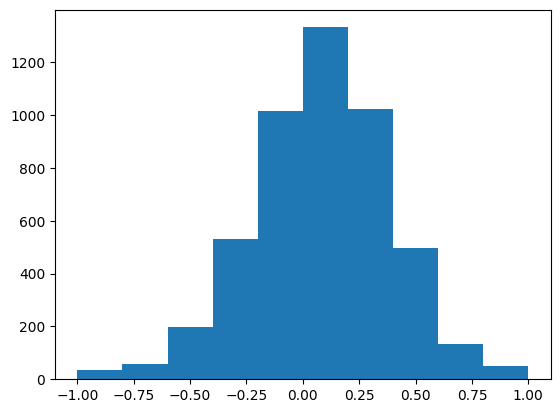

In [11]:
import matplotlib.pyplot as plt
plt.hist(correlations['CHK1_HUMAN'])
plt.show()

In [12]:
# A lot of correlations, but they seem spurious
drug_high_correlations = correlations['CHK1_HUMAN'][correlations['CHK1_HUMAN'] > 0.7]
drug_high_correlations

Protein
6PGL_HUMAN     1.000000
AAR2_HUMAN     1.000000
ALG2_HUMAN     0.872456
APTX_HUMAN     0.921205
ARK72_HUMAN    1.000000
                 ...   
VPS4B_HUMAN    0.752339
ZBED1_HUMAN    0.897341
ZBT21_HUMAN    0.751921
ZN669_HUMAN    0.894849
ZNF79_HUMAN    1.000000
Name: CHK1_HUMAN, Length: 89, dtype: float64

In [13]:
# Saving a dataframe of group comparison output with high correlation proteins for R
correlations_df = df.loc[df['Protein'].isin(drug_high_correlations.keys())]
correlations_df.to_csv("modelCorrelations.csv", na_rep='NA')

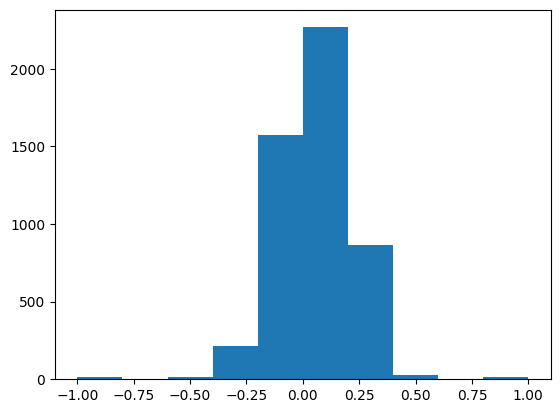

In [14]:
dmso_data = data[data["GROUP"] == "DMSO"]
dmso_data = dmso_data[['Protein', 'originalRUN', 'LogIntensities']]
wide_data = dmso_data.pivot(index='originalRUN', columns='Protein', values='LogIntensities')
wide_data = wide_data.iloc[:, 1:]
correlations = wide_data.corr()
plt.hist(correlations['CHK1_HUMAN'])
plt.show()

In [15]:
# Less correlations in DMSO
high_correlations = correlations['CHK1_HUMAN'][correlations['CHK1_HUMAN'] > 0.7]
high_correlations

Protein
AATM_HUMAN     0.924316
ANXA8_HUMAN    1.000000
CHK1_HUMAN     1.000000
CUX2_HUMAN     0.773711
GGCT_HUMAN     0.901591
H2B1N_HUMAN    1.000000
MGLL_HUMAN     1.000000
PSAL_HUMAN     0.947190
RAB6D_HUMAN    0.943109
SBP1_HUMAN     1.000000
TOIP2_HUMAN    0.854246
TRI29_HUMAN    0.892090
Z804A_HUMAN    1.000000
Name: CHK1_HUMAN, dtype: float64

## STEP 4: QUERY INDRA NETWORK SEARCH

In [16]:
import requests

def query_indra_network_search(source, target, path_length = 3):
    """Return a list INDRA network search."""
    res = requests.post(
        'https://network.indra.bio/api/query',
        json={
            'source': source,
            'target': target,
            'path_length': path_length,
            'user_timeout': 30,
            'k_shortest': 50,
            'curated_db_only': False,
            'format': 'json',
            'stmt_filter':['Phosphorylation','Complex','IncreaseAmount','DecreaseAmount'],
            'allowed_ns':['hgnc'],
            'mesh_ids':['D000074084'],
            'weighted':'context'
        }
    )
    return res.json()

In [ ]:
responses = {}
for index, source in source_df.iterrows():
    for protein in drug_high_correlations.keys():
        target = hgnc_client.get_hgnc_name(uniprot_to_hgnc_id(protein))
        responses[protein] = query_indra_network_search(source['HgncName'], target)

In [311]:
responses = {}
path_length = 3
for index, source in source_df.iterrows():
    for index2, target in pandas_df.iterrows():
        responses[target['Protein']] = query_indra_network_search(source['HgncName'], target['HgncName'], path_length)

In [312]:
responses['CLH1_HUMAN']['path_results']['paths'][str(path_length)][0]['path']

[{'name': 'CHEK1',
  'namespace': 'HGNC',
  'identifier': '1925',
  'lookup': 'https://identifiers.org/hgnc:1925',
  'sign': None},
 {'name': 'ATR',
  'namespace': 'HGNC',
  'identifier': '882',
  'lookup': 'https://identifiers.org/hgnc:882',
  'sign': None},
 {'name': 'CLTC',
  'namespace': 'HGNC',
  'identifier': '2092',
  'lookup': 'https://identifiers.org/hgnc:2092',
  'sign': None}]

In [313]:
responses['CLH1_HUMAN']['path_results']['paths'][str(path_length)][0]['edge_data']

[{'edge': [{'name': 'CHEK1',
    'namespace': 'HGNC',
    'identifier': '1925',
    'lookup': 'https://identifiers.org/hgnc:1925',
    'sign': None},
   {'name': 'ATR',
    'namespace': 'HGNC',
    'identifier': '882',
    'lookup': 'https://identifiers.org/hgnc:882',
    'sign': None}],
  'statements': {'Phosphorylation': {'stmt_type': 'Phosphorylation',
    'source_counts': {'reach': 14, 'isi': 3, 'medscan': 1, 'sparser': 3},
    'statements': [{'stmt_type': 'Phosphorylation',
      'evidence_count': 20,
      'stmt_hash': -7055947699060479,
      'source_counts': {'reach': 13, 'isi': 3, 'medscan': 1, 'sparser': 3},
      'belief': 0.9998962424007463,
      'curated': False,
      'english': 'CHEK1 phosphorylates ATR.',
      'weight': 0.00010376298244580924,
      'residue': None,
      'position': None,
      'initial_sign': None,
      'db_url_hash': 'https://db.indra.bio/statements/from_hash/-7055947699060479?format=html'},
     {'stmt_type': 'Phosphorylation',
      'evidence_co

In [314]:
# FILTER BASED ON PATHWAYS THAT ARE LATENT
z = responses['CLH1_HUMAN'] # CLH1_HUMAN, FCGRN_HUMAN, NECP2_HUMAN, RFA1_HUMAN
paths = []
for path in z['path_results']['paths'][str(path_length)]:
    isLatent = False
    for index, edge in enumerate(path['path']):
        if edge['namespace'] != 'HGNC' or edge['identifier'] not in df['HgncId'].values:
            isLatent = True
    if not isLatent:
        paths.append(path)            

In [ ]:
# FILTER BASED ON PATHWAYS THAT CONTAIN:
# KINASE -> KINASE -> TF
# PHOSPHORYLATION / INCREASE AMOUNT statements
# LATENT VS NOT LATENT, i.e. HGNC ID is in df
# create node and edge DF for visualizeSubnetworks
z = responses['CLH1_HUMAN'] # CLH1_HUMAN, FCGRN_HUMAN, NECP2_HUMAN, RFA1_HUMAN
paths = []
for path in z['path_results']['paths'][str(path_length)]:
    isLatent = False
    isKinaseTF = True
    isComplexModifyAmount = True
    for index, edge in enumerate(path['path']):
        if edge['namespace'] != 'HGNC' or edge['identifier'] not in df['HgncId'].values:
            isLatent = True
            if edge['namespace'] == 'HGNC':
                gene = hgnc_client.get_hgnc_name(edge['identifier'])
                isKinase = hgnc_client.is_kinase(gene)
                isTranscriptionFactor = hgnc_client.is_transcription_factor(gene)
                if not isKinase and not isTranscriptionFactor:
                    isKinaseTF = False
        else:
            if index != len(path['path']) - 1:
                row = df[df['HgncId'] == edge['identifier']]
                isKinase = row['IsKinase'].bool()
                isTranscriptionFactor = row['IsTranscriptionFactor'].bool()
                if not isKinase and not isTranscriptionFactor:
                    isKinaseTF = False
    for index, edge in enumerate(path['edge_data']):
        if index != len(path['edge_data']) - 1:
            if 'Phosphorylation' not in edge['statements'].keys():
                isKinaseTF = False

        else:
            if not set(['Complex', 'IncreaseAmount', 'DecreaseAmount']).intersection(edge['statements'].keys()):
                isComplexModifyAmount = False

    
    if not isLatent and isKinaseTF and isComplexModifyAmount:
        paths.append(path)

## STEP 5: QUERY INDRA COGEX

Using INDRA Cogex, we can extract subnetwork relationships among the proteins from the MSstats output.

In [96]:
import requests

def query_indra_subnetwork(groundings):
    """Return a list INDRA subnetwork relations based on a list of groundings."""
    res = requests.post(
        'https://discovery.indra.bio/api/indra_subnetwork_relations',
        json={'nodes': groundings}
    )
    return res.json()

In [103]:
groundings = []
for hgnc_id in pandas_df["HgncId"]:
    groundings.append(('HGNC', hgnc_id))
subnetwork_relations = query_indra_subnetwork(groundings)
len(subnetwork_relations)

2

In [102]:
groundings = []
for protein in drug_high_correlations.keys():
    hgnc_id = uniprot_to_hgnc_id(protein)
    groundings.append(('HGNC', hgnc_id))
subnetwork_relations = query_indra_subnetwork(groundings)
len(subnetwork_relations)

106

## STEP 6: ASSEMBLE DATA

INDRA has a set of assembler classes to display the data for further analysis.  Below are some examples of assemblers

### HTML Assembler

In [13]:
import json
from indra.statements import stmts_from_json

# Gather statistics for HTML presentation
unique_stmts = {entry['data']['stmt_hash']: json.loads(entry['data']['stmt_json'])
                for entry in subnetwork_relations}
ev_counts_by_hash = {entry['data']['stmt_hash']: entry['data']['evidence_count']
                     for entry in subnetwork_relations}
source_counts_by_hash = {entry['data']['stmt_hash']: json.loads(entry['data']['source_counts'])
                         for entry in subnetwork_relations}
stmts = stmts_from_json(list(unique_stmts.values()))

In [14]:
from indra.assemblers.html import HtmlAssembler
ha = HtmlAssembler(stmts,
                   title='INDRA subnetwork statements',
                   db_rest_url='https://db.indra.bio',
                   ev_counts=ev_counts_by_hash,
                   source_counts=source_counts_by_hash)
html_str = ha.make_model()

In [15]:
from IPython.core.display import HTML
HTML(html_str)

### NETWORK VISUALIZATION

We can also visualize the subnetwork acquired from INDRA Cogex using an INDRA built-in assembler

In [21]:
from indra.assemblers.graph.assembler import GraphAssembler

ga = GraphAssembler(stmts=stmts)
ga.make_model()
ga.save_pdf(file_name='graph.pdf', prog='dot')

### Tabular Format

INDRA also has an assembler for displaying INDRA cogex results as a table.

In [22]:
from indra.assemblers.indranet.assembler import IndraNetAssembler

def add_evidence_column(stmt, ev_counts = ev_counts_by_hash):
    hash = stmt.get_hash(refresh=True)
    return ev_counts[hash]

indra_net_assembler = IndraNetAssembler(statements=stmts)
relations_table = indra_net_assembler.make_df(extra_columns=[('evidence_count', add_evidence_column)])
relations_table = relations_table.sort_values(by=['evidence_count'], ascending=False)
relations_table

,agA_name,agB_name,agA_ns,agA_id,agB_ns,agB_id,residue,position,stmt_type,evidence_count,stmt_hash,belief,source_counts,initial_sign
7,CHEK1,RPA1,HGNC,1925,HGNC,10289,None,None,Phosphorylation,16,22039018332715694,0.999082,{'sparser': 1},None
5,RPA1,CHEK1,HGNC,10289,HGNC,1925,None,None,Phosphorylation,3,6298771024467860,0.923000,{'reach': 1},None
4,RPA1,CHEK1,HGNC,10289,HGNC,1925,None,None,Dephosphorylation,2,9751777159668901,0.941900,{'reach': 1},None
0,RPA1,CLTC,HGNC,10289,HGNC,2092,None,None,Complex,1,13959655286867654,0.980000,{'biogrid': 1},None
1,CLTC,RPA1,HGNC,2092,HGNC,10289,None,None,Complex,1,13959655286867654,0.980000,{'biogrid': 1},None
2,RPA1,CHEK1,HGNC,10289,HGNC,1925,S,345,Dephosphorylation,1,-4359730843333697,0.650000,{'reach': 1},None
3,RPA1,CHEK1,HGNC,10289,HGNC,1925,None,None,Activation,1,-22751136463918078,0.650000,{'reach': 1},None
6,RPA1,CHEK1,HGNC,10289,HGNC,1925,None,None,Dephosphorylation,1,-28824006899253340,0.650000,{'reach': 1},None
8,CHEK1,RPA1,HGNC,1925,HGNC,10289,None,None,Inhibition,1,-891482891587470,0.650000,{'reach': 1},None


In [27]:
from indra.assemblers.cx import CxAssembler

ca = CxAssembler(stmts, 'INDRA May Institute Network')
ncx = ca.make_model()
ca.save_model()

### Correlation Matrix

In [45]:
ABUNDANCE_PATH = "ProteinLevelData.csv" # Set this path yourself
ABUNDANCE_GROUPS_FILTER = ['PF477736']
def construct_abundance_df(filename):
    pandas_df = pd.read_csv(filename)
    pandas_df = pandas_df[pandas_df['GROUP'].isin(ABUNDANCE_GROUPS_FILTER)]
    return pandas_df

protein_abundance_df = construct_abundance_df(ABUNDANCE_PATH)
protein_abundance_df

,RUN,Protein,LogIntensities,originalRUN,GROUP,SUBJECT,TotalGroupMeasurements,NumMeasuredFeature,MissingPercentage,more50missing,NumImputedFeature
218,219,1433B_HUMAN,12.816965,230719_THP-1_Chrom_end2end_Plate1_PF477736_A07...,PF477736,7,153,10,0.0,False,0
219,220,1433B_HUMAN,12.484859,230719_THP-1_Chrom_end2end_Plate1_PF477736_C05...,PF477736,28,153,10,0.0,False,0
220,221,1433B_HUMAN,12.062958,230719_THP-1_Chrom_end2end_Plate1_PF477736_F03...,PF477736,62,153,10,0.0,False,0
221,222,1433B_HUMAN,11.954326,230719_THP-1_Chrom_end2end_Plate1_PF477736_F12...,PF477736,71,153,9,0.1,False,0
222,223,1433B_HUMAN,12.032965,230719_THP-1_Chrom_end2end_Plate1_PF477736_G12...,PF477736,83,153,10,0.0,False,0
...,...,...,...,...,...,...,...,...,...,...,...
1189787,232,ZZZ3_HUMAN,10.369426,230719_THP-1_Chrom_end2end_Plate3_VE-821_D08,PF477736,236,179,10,0.0,False,0
1189788,233,ZZZ3_HUMAN,10.587775,230719_THP-1_Chrom_end2end_Plate3_DbET6_E08,PF477736,248,179,10,0.0,False,0
1189789,234,ZZZ3_HUMAN,10.755412,230719_THP-1_Chrom_end2end_Plate3_DMSO_E10,PF477736,250,179,10,0.0,False,0
1189790,235,ZZZ3_HUMAN,10.653718,230719_THP-1_Chrom_end2end_Plate3_DMSO_F01,PF477736,253,179,10,0.0,False,0


The `dataProcess` function outputs a dataset containing protein abundances for protein and biological replicate pair.  Using the protein abundances data, we can determine the correlation of abundance between pairs of proteins.

In [46]:
import numpy as np
def calculate_correlation_matrix(pvalue_df, protein_level_summary):
    data = {}
    subjects = protein_level_summary['SUBJECT'].unique()
    for protein in pvalue_df['Protein'].unique():
        data[protein] = []
        protein_level_df = protein_level_summary[protein_level_summary['Protein'] == protein]
        for subject in subjects:
            if subject in protein_level_df['SUBJECT'].values:
                protein_level_df_subject = protein_level_df[protein_level_df['SUBJECT'] == subject]
                data[protein].append(protein_level_df_subject['LogIntensities'].iloc[0])
            else:
                data[protein].append(np.nan)
    df = pd.DataFrame(data)
    corrM = df.corr() 
    return corrM

corr_matrix = calculate_correlation_matrix(pvalue_logfc_df, protein_abundance_df)
corr_matrix

,CHK1_HUMAN,CLH1_HUMAN,FCGRN_HUMAN,NECP2_HUMAN,RFA1_HUMAN
CHK1_HUMAN,1.000000,-0.353624,-0.500364,0.418754,0.699927
CLH1_HUMAN,-0.353624,1.000000,0.613517,-0.152550,-0.489436
FCGRN_HUMAN,-0.500364,0.613517,1.000000,-0.293231,-0.498986
NECP2_HUMAN,0.418754,-0.152550,-0.293231,1.000000,0.385696
RFA1_HUMAN,0.699927,-0.489436,-0.498986,0.385696,1.000000


In [47]:
LOG_FC_FILTER = 0.25
pvalue_logfc_df['log2FC'] = pvalue_logfc_df['log2FC'].astype(float)
logfc_proteins = pvalue_logfc_df[pvalue_logfc_df['log2FC'].abs() > LOG_FC_FILTER]
logfc_proteins

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
32541,CLH1_HUMAN,DMSO-PF477736,-0.269784,0.056036,-4.814489,260.0,2.506764e-06,3.094600e-03,NaN,0.143333,0.0
63546,FCGRN_HUMAN,DMSO-PF477736,-0.674851,0.132991,-5.074427,179.0,9.674775e-07,1.592468e-03,NaN,0.195918,0.0
115656,NECP2_HUMAN,DMSO-PF477736,0.693701,0.097077,7.145875,259.0,9.076739e-12,2.241047e-08,NaN,0.040000,0.0
152151,RFA1_HUMAN,DMSO-PF477736,-0.603824,0.076190,-7.925239,260.0,6.705747e-14,3.311298e-10,NaN,0.120667,0.0


We can get an explanation from analyzing the INDRA statements.  The drug is supposed to inhibit CHEK1.  Because there is less CHEK1 phospho activity, RPA1 increases in activity since CHEK1 inhibits RPA1.  RPA1 increasing in activity could lead to more RPA1 abundance in the nucleus (as opposed to the cytoplasm), which can then cause CLTC to go up since RPA1 binds CLTC.  